# 0. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import altair as alt


from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder
)

from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    RandomizedSearchCV,
    GridSearchCV
)

from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.feature_selection import RFE, RFECV

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    plot_confusion_matrix,
    precision_score,
    plot_precision_recall_curve,
    recall_score
)
import eli5
import shap
import matplotlib.pyplot as plt

chosen_seed = 2021

/home/debananda/miniconda3/envs/573/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/debananda/miniconda3/envs/573/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# 1. Reading Data

In [2]:
data_df = pd.read_csv("data/train.csv", index_col="PassengerId")
deploy_df = pd.read_csv("data/test.csv", index_col="PassengerId")
deploy_df

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


# 2. Data Splitting

In [3]:
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=chosen_seed)
print(train_df.shape)
print(test_df.shape)

(712, 11)
(179, 11)


# 3. Basic EDA

## 3.1 High level summary

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 91 to 117
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  712 non-null    int64  
 1   Pclass    712 non-null    int64  
 2   Name      712 non-null    object 
 3   Sex       712 non-null    object 
 4   Age       575 non-null    float64
 5   SibSp     712 non-null    int64  
 6   Parch     712 non-null    int64  
 7   Ticket    712 non-null    object 
 8   Fare      712 non-null    float64
 9   Cabin     170 non-null    object 
 10  Embarked  711 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 66.8+ KB


In [5]:
train_df.describe(include="all")

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,712.000000,712.000000,712,712,575.000000,712.000000,712.000000,712,712.000000,170,711
unique,NaN,NaN,712,2,NaN,NaN,NaN,565,NaN,131,3
top,NaN,NaN,"Reeves, Mr. David",male,NaN,NaN,NaN,347082,NaN,C23 C25 C27,S
freq,NaN,NaN,1,461,NaN,NaN,NaN,6,NaN,4,514
mean,0.380618,2.285112,NaN,NaN,29.414783,0.533708,0.391854,NaN,33.388155,NaN,NaN
std,0.485880,0.842875,NaN,NaN,14.589601,1.099284,0.802311,NaN,50.807818,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,0.000000,1.000000,NaN,NaN,20.000000,0.000000,0.000000,NaN,7.925000,NaN,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,15.047900,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,37.000000,1.000000,0.000000,NaN,31.387500,NaN,NaN


## 3.2 Analyzing Nulls

In [6]:
na_summary = train_df.isna().sum().reset_index(name="na_count").query("na_count != 0")
na_summary["perc"] = na_summary["na_count"] / train_df.shape[0] * 100
na_summary

,index,na_count,perc
4,Age,137,19.241573
9,Cabin,542,76.123596
10,Embarked,1,0.140449


Observations:
- We have 77% nulls in Cabin. Hence we will not use this feature
- We only have 2 missing values in Embarked. Creating a new category called `missing` may not be useful as we only have 2 records to learn from. We will impute this with most frequent value
- We have around 20% nulls in age. We will look into it in details to find out an imputation strategy

## 3.3 EDA - Initial feature classification

- This classification is based on our initial understanding of the data
- It will be used for EDA only
- This is subjected to change based on our findings from EDA

In [7]:
numeric_features = ["Age", "SibSp" ,"Parch", "Fare"]
categorical_features = ["Sex", "Embarked"]
ordinal_features = ["Pclass"]
remainder_features = []
drop_features = ["Name", "Ticket", "Cabin"]

## 3.4 EDA - Numeric features

In [8]:
numeric_plots = alt.Chart(train_df).mark_line(interpolate="step").encode(
    x=alt.X(alt.repeat("repeat"), type="quantitative", bin=alt.Bin(maxbins=20)), y="count()", color="Survived:N"
).properties(width=200, height=100).repeat(repeat = numeric_features, columns=2)
numeric_plots

alt.RepeatChart(...)

In [9]:
numeric_plots = (
    alt.Chart(train_df.reset_index())
    .mark_point(opacity=0.2, size=5)
    .encode(
        x=alt.X(alt.repeat("column"), type="quantitative"),
        y=alt.X(alt.repeat("row"), type="quantitative"),
        tooltip="PassengerId"
    )
    .properties(width=180, height=100)
    .repeat(column=numeric_features, row=numeric_features)
)
numeric_plots

alt.RepeatChart(...)

In [10]:
# correlation chart all variable
corr_df = train_df[numeric_features].corr().stack().reset_index(name="corr")
corr_df["round_corr"] = np.round(corr_df["corr"], 2)
corr_plot = (
    alt.Chart(
        corr_df.query("level_0 != 'is_canceled' & level_1 != 'is_canceled'"),
        title="Feature Correlation",
    )
    .mark_rect()
    .encode(
        x="level_0",
        y="level_1",
        tooltip="corr",
        color=alt.Color(
            "corr", scale=alt.Scale(domain=(-1, 1), scheme="purpleorange")
        ),
    )
    .properties(width=300, height=300)
)
corr_text = (
    alt.Chart(corr_df.query("level_0 != 'is_canceled' & level_1 != 'is_canceled'"))
    .mark_text(size=12)
    .encode(
        x=alt.X("level_0", title="Features"),
        y=alt.Y("level_1", title="Features"),
        text="round_corr",
    )
)
corr_all = corr_plot + corr_text
corr_all

alt.LayerChart(...)

**Observations:**

- Passenger ID 738, 259 looks like an outlier in terms of Fare
- Fare is heavily skewed, we will try log transformation
- Parch and SibSp looks like ordinal feature. We will try to engineer new features from them

## 3.5 EDA - Categorical vs numerical features

In [11]:
numeric_features = ["Age", "Fare"]
categorical_features = ["Sex", "Embarked"]
ordinal_features = ["Pclass", "SibSp", "Parch"]
remainder_features = []
drop_features = ["Name", "Ticket", "Cabin"]

In [12]:
cat_vs_num_plots = (
    alt.Chart(train_df.reset_index())
    .mark_boxplot()
    .encode(
        x=alt.X(alt.repeat("column"), type="quantitative"),
        y=alt.X(alt.repeat("row"), type="nominal"),
        tooltip="PassengerId"
    )
    .properties(width=180, height=100)
    .repeat(column=numeric_features, row=ordinal_features + categorical_features + ["Survived"])
)
cat_vs_num_plots

alt.RepeatChart(...)

**Observations:**

- Passenger ID 738, 259 looks like an outlier in terms of Fare. But they both survived. Hence, we will not remove them and try to scale the data to make them relevant
- Age has significant correlation with Sex and Pclass

## 3.6 EDA - Categorical vs categorical features

In [13]:
categorical_plots = (
    alt.Chart(train_df)
    .mark_circle()
    .encode(
        x=alt.X(alt.repeat("column"), type="nominal"),
        y=alt.X(alt.repeat("row"), type="nominal"),
        size="count()"
    )
    .properties(width=180, height=100)
    .repeat(
        column=ordinal_features + categorical_features + ["Survived"],
        row=ordinal_features + categorical_features + ["Survived"],
    )
)
categorical_plots

alt.RepeatChart(...)

**Observations:**

- Pclass is strongly related with Survived and Embarked. It will suit more as ordinal feature
- Sex is significant factor for survival
- C Embarkment has more chance of survival

## 3.7 EDA - Class Imbalance

In [14]:
class_df = train_df.value_counts("Survived").reset_index(name = "n_observations")
class_df = class_df.assign(perc = class_df["n_observations"]/ train_df.shape[0]*100)
class_df

,Survived,n_observations,perc
0,0,441,61.938202
1,1,271,38.061798


**Observation:**
    
- We have class imbalance.
- 62% of training data indicate non defaulters
- 38% of training data indicate defaults
- We will use f1-score as our validation metric, as we would like to maximize both precision and recall
- We will also keep as eye on the accuracy

## 3.8 EDA - Summary

In [15]:
train_df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

| Feature | Type | Comments |
|---------|------|----------|
| Survived | Response | Class Imbalance. Will use F1-score as metric |
| Pclass | Ordinal | Very significant |
| Name | Drop | Can be used for feature engineering in future |
| Sex | Categorical | Very significant. We are considering it non-binary to include other sexes as well |
| Age | Numerical | Significant. Can be used for feature engineering in future |
| SibSp | Count | Not very significant but can be used for feature engineering |
| Parch | Count | Not very significant but can be used for feature engineering |
| Ticket | Drop | Can be used for feature engineering in future |
| Cabin | Drop | 76% values are NULL |
| Embarked | Categorical | Significant |

# 4. Feature engineering

## 4.1 Log of Fare

In [16]:
train_df = train_df.assign(fare_log = np.log(train_df.Fare + 1))
test_df = test_df.assign(fare_log = np.log(test_df.Fare + 1))
deploy_df = deploy_df.assign(fare_log = np.log(deploy_df.Fare + 1))
data_df = data_df.assign(fare_log = np.log(data_df.Fare + 1))
numeric_features.append("fare_log")

In [17]:
numeric_plots = alt.Chart(train_df).mark_line(interpolate="monotone").encode(
    x=alt.X("fare_log", bin=alt.Bin(maxbins=10)), 
    y="count()", 
    color="Survived:N"
).properties(width=200, height=100)
numeric_plots

alt.Chart(...)

In [18]:
numeric_plots = (
    alt.Chart(train_df.reset_index())
    .mark_point(opacity=0.2, size=5)
    .encode(
        x=alt.X("fare_log"),
        y=alt.X(alt.repeat("repeat"), type="quantitative"),
        tooltip="PassengerId"
    )
    .properties(width=180, height=100)
    .repeat(repeat=numeric_features)
)
numeric_plots

alt.RepeatChart(...)

In [19]:
cat_vs_num_plots = (
    alt.Chart(train_df.reset_index())
    .mark_boxplot()
    .encode(
        x=alt.X("fare_log"),
        y=alt.X(alt.repeat("repeat"), type="nominal"),
        tooltip="PassengerId"
    )
    .properties(width=180, height=100)
    .repeat(repeat=ordinal_features + categorical_features + ["Survived"], columns=3)
)
cat_vs_num_plots

alt.RepeatChart(...)

**Observations:**

- The distribution of log of fare looks close to normal
- The Categorical features vs log of fare shows that log of fare has more significance than fare
- We will use both fare and log of fare in our model initially

## 4.2 Combining SibSp and Parch

- In this step we will perform the following operation
    - Add SibSp and Parch and store it in n_associated_members (ordinal)
    - If n_associated_members > 10 than set it 11 to indicate 10 or above
    - If SibSp > 10 than set it 11 to indicate 10 or above
    - If Parch > 10 than set it 11 to indicate 10 or above
    - Create a binary feature names is_alone

In [20]:
train_df = train_df.assign(n_associated_members = train_df["SibSp"] + train_df["Parch"])
test_df = test_df.assign(n_associated_members = test_df["SibSp"] + test_df["Parch"])
deploy_df = deploy_df.assign(n_associated_members = deploy_df["SibSp"] + deploy_df["Parch"])
data_df = data_df.assign(n_associated_members = data_df["SibSp"] + data_df["Parch"])

In [21]:
train_df.loc[train_df.n_associated_members>10, "n_associated_members"] = 11
test_df.loc[test_df.n_associated_members>10, "n_associated_members"] = 11
deploy_df.loc[deploy_df.n_associated_members>10, "n_associated_members"] = 11
data_df.loc[data_df.n_associated_members>10, "n_associated_members"] = 11

In [22]:
train_df.loc[train_df.SibSp>10, "SibSp"] = 11
test_df.loc[test_df.SibSp>10, "SibSp"] = 11
deploy_df.loc[deploy_df.SibSp>10, "SibSp"] = 11
data_df.loc[data_df.SibSp>10, "SibSp"] = 11

In [23]:
train_df.loc[train_df.Parch>10, "Parch"] = 11
test_df.loc[test_df.Parch>10, "Parch"] = 11
deploy_df.loc[deploy_df.Parch>10, "Parch"] = 11
data_df.loc[data_df.Parch>10, "Parch"] = 11

In [24]:
train_df = train_df.assign(
    is_alone=pd.Series(
        train_df.n_associated_members.apply(lambda x: 1 if x == 0 else 0),
        name="is_alone",
    )
)

test_df = test_df.assign(
    is_alone=pd.Series(
        test_df.n_associated_members.apply(lambda x: 1 if x == 0 else 0),
        name="is_alone",
    )
)

deploy_df = deploy_df.assign(
    is_alone=pd.Series(
        deploy_df.n_associated_members.apply(lambda x: 1 if x == 0 else 0),
        name="is_alone",
    )
)

data_df = data_df.assign(
    is_alone=pd.Series(
        data_df.n_associated_members.apply(lambda x: 1 if x == 0 else 0),
        name="is_alone",
    )
)

In [25]:
binary_feature = ["is_alone"]
ordinal_features.append("n_associated_members")

In [26]:
cat_vs_num_plots = (
    alt.Chart(train_df)
    .mark_boxplot()
    .encode(
        x=alt.X(alt.repeat("column"), type="quantitative"),
        y=alt.X(alt.repeat("row"), type="nominal"),
    )
    .properties(width=180, height=200)
    .repeat(
        column=numeric_features,
        row=["is_alone" , "n_associated_members"],
    )
)
cat_vs_num_plots

alt.RepeatChart(...)

In [27]:
categorical_plots = (
    alt.Chart(train_df)
    .mark_circle()
    .encode(
        x=alt.X(alt.repeat("column"), type="nominal"),
        y=alt.X(alt.repeat("row"), type="nominal"),
        size="count()"
    )
    .properties(width=180, height=100)
    .repeat(
        column=["is_alone" , "n_associated_members"],
        row=ordinal_features + categorical_features + binary_feature + ["Survived"],
    )
)
categorical_plots

alt.RepeatChart(...)

**Observations:**

- We see that is_alone, n_associated_members has some relation with Age and Log of Fare
- is_alone and n_associated_members are correlated. We expect to get rid of one of them during feature selection/ elimination.

In [28]:
# print(f"numeric_features: {numeric_features}")
# print(f"categorical_features: {categorical_features}")
# print(f"ordinal_features: {ordinal_features}")
# print(f"remainder_features: {remainder_features}")
# print(f"drop_features: {drop_features}")
# print(f"binary_feature: {binary_feature}")
# train_df.columns

# 5. Preprocessing

From the column description and quick look at the values, we distribute the features in below categories:

In [29]:
numeric_features = ['Age', 'Fare', 'fare_log']
categorical_features = ["Sex", "Embarked"]
ordinal_features = ['Pclass', 'SibSp', 'Parch', 'n_associated_members']
remainder_features = []
binary_features= ['is_alone']
drop_features = ["Name", "Ticket", "Cabin"]

In [30]:
numeric_pipeline_median = make_pipeline(
    SimpleImputer(strategy="median"), StandardScaler()
)
categorical_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"),
)

ordinal_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=[[1, 2, 3]] + [np.arange(0, 12).tolist()] * 3),
)

binary_pipeline = make_pipeline(SimpleImputer(strategy="constant", fill_value=1))

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline_median, numeric_features),
        ("cat", categorical_pipeline, categorical_features),
        ("ord", ordinal_pipeline, ordinal_features),
        ("bin", binary_pipeline, binary_features)
    ],
    remainder="drop",
)

In [31]:
X_train, y_train = train_df.drop(columns=["Survived"]), train_df["Survived"]
X_test, y_test = test_df.drop(columns=["Survived"]), test_df["Survived"]

## 5.1 Housekeeping

In [32]:
def summarize_cv_scores(X, classifier_name):
    """
    This function summarizes the output of cross_validate function 
    from sklearn.model_selection and provides the mean and 
    standard deviation of all columns.

    Parameters
    ----------
    X : dict
        The output of cross_validate function from sklearn.model_selection.

    classifier_name : string
        Name of the classifier

    Examples
    --------
    Constructing toy example for X dictionary.

    >>> toy_score = {
        "fit_time": np.array([0.1, 0.2, 0.3, 0.4, 0.5]),
        "score_time": np.array([1, 2, 3, 4, 5]),
        "test_accuracy": np.array([0.5, 0.5, 0.5, 0.5, 0.5]),
        "train_accuracy": np.array([0.5, 0.5, 0.5, 0.5, 0.5]),
        "test_f1": np.array([0.1, 0.1, 0.2, 0.1, 0.1]),
        "train_f1": np.array([0.1, 0.3, 0.1, 0.1, 0.1]),
    }
    
    Using the function
    
    >>> summarize_cv_scores(toy_score, "toy_test")
    """
    X_df = pd.DataFrame(X)
    col_names = (
        pd.Series(X_df.columns.tolist()).str.replace("test_", "validation_").tolist()
    )
    col_names = [f"{t}_{i}" for t in ["mean", "std"] for i in col_names]
    X_df = pd.DataFrame(pd.concat([X_df.mean(), X_df.std()])).T
    X_df.columns = col_names
    X_df["classifier_name"] = classifier_name
    col_names = ["classifier_name"] + col_names
    return X_df[col_names]


toy_score = {
    "fit_time": np.array([0.1, 0.2, 0.3, 0.4, 0.5]),
    "score_time": np.array([1, 2, 3, 4, 5]),
    "test_accuracy": np.array([0.5, 0.5, 0.5, 0.5, 0.5]),
    "train_accuracy": np.array([0.5, 0.5, 0.5, 0.5, 0.5]),
    "test_f1": np.array([0.1, 0.1, 0.2, 0.1, 0.1]),
    "train_f1": np.array([0.1, 0.3, 0.1, 0.1, 0.1]),
}

expected = {
    "classifier_name": ["toy_test"],
    "mean_fit_time": [0.3],
    "mean_score_time": [3],
    "mean_validation_accuracy": [0.5],
    "mean_train_accuracy": [0.5],
    "mean_validation_f1": [0.12],
    "mean_train_f1": [0.14],
    "std_fit_time": [0.158114],
    "std_score_time": [1.581139],
    "std_validation_accuracy": [0.0],
    "std_train_accuracy": [0.0],
    "std_validation_f1": [0.044721],
    "std_train_f1": [0.089443],
}


assert isinstance(
    summarize_cv_scores(toy_score, "toy_test"), pd.DataFrame
), "Check data structure"
assert (
    int(
        (
            np.round(summarize_cv_scores(toy_score, "toy_test"), 4)
            == np.round(pd.DataFrame(data=expected), 4)
        ).T.sum()
    )
    == 13
), "Check function logic"
print("Success!")

Success!


# 6. Building a baseline model

In [33]:
evaluation_metrics = ["f1", "accuracy"]
model_dummy = DummyClassifier(strategy="stratified", random_state=chosen_seed)
scores = cross_validate(
    model_dummy,
    X_train,
    y_train,
    scoring=evaluation_metrics,
    cv=5,
    n_jobs=-1,
    return_train_score=True,
)
scores_df = summarize_cv_scores(scores, "Dummy Classifier")
scores_df

,classifier_name,mean_fit_time,mean_score_time,mean_validation_f1,mean_train_f1,mean_validation_accuracy,mean_train_accuracy,std_fit_time,std_score_time,std_validation_f1,std_train_f1,std_validation_accuracy,std_train_accuracy
0,Dummy Classifier,0.001445,0.00327,0.42679,0.386544,0.532316,0.526345,0.000111,0.000183,0.032056,0.020684,0.024699,0.015696


# 7. Trying other classifiers

In [34]:
def classifier_eval(X_train, y_train, preprocessor, chosen_seed, scores_df):
    classifiers = {
        "Logistic Regression": make_pipeline(
            preprocessor,
            LogisticRegression(n_jobs=-1, max_iter=2000, random_state=chosen_seed),
        ),
        "Decision Tree": make_pipeline(
            preprocessor,
            DecisionTreeClassifier(random_state=chosen_seed, #class_weight="balanced"
                                  ),
        ),
        "kNN": make_pipeline(preprocessor, KNeighborsClassifier(n_jobs=-1)),
        "SVC RBF": make_pipeline(
            preprocessor, SVC(class_weight="balanced", random_state=chosen_seed)
        ),
        # "Naive Bayes": MultinomialNB(),
        "Random Forest": make_pipeline(
            preprocessor,
            RandomForestClassifier(
                n_estimators=1000,
                n_jobs=-1,
                random_state=chosen_seed,
                # class_weight="balanced",
            ),
        ),
        "XGB Classifier": make_pipeline(
            preprocessor,
            XGBClassifier(random_state=chosen_seed, n_jobs=-1, # scale_pos_weight=1.63
                         ),
        ),
        "LGBM Classifier": make_pipeline(
            preprocessor,
            LGBMClassifier(random_state=chosen_seed, n_jobs=-1, # class_weight="balanced"
                          ),
        ),
        "CatBoost Classifier": make_pipeline(
            preprocessor,
            CatBoostClassifier(
                verbose=0,
                random_state=chosen_seed,
                thread_count=-1,
                # class_weights=[1, 1.63],
            ),
        ),
    }
    
    for c in classifiers:
        print(f"Evaluating {c}")
        model_pipe = classifiers[c]
        scores = cross_validate(
            model_pipe,
            X_train,
            y_train,
            scoring=evaluation_metrics,
            cv=5,
            n_jobs=-1,
            return_train_score=True,
        )
        scores_df = pd.concat(
            [scores_df, summarize_cv_scores(scores, c)], ignore_index=True
        )
    print("Evaluation completed")
    
    return scores_df

In [35]:
scores_df = classifier_eval(X_train, y_train, preprocessor, chosen_seed, scores_df)

Evaluating Logistic Regression
Evaluating Decision Tree
Evaluating kNN
Evaluating SVC RBF
Evaluating Random Forest
Evaluating XGB Classifier
Evaluating LGBM Classifier
Evaluating CatBoost Classifier
Evaluation completed


In [36]:
scores_df.sort_values(by="mean_validation_f1", ascending=False)

,classifier_name,mean_fit_time,mean_score_time,mean_validation_f1,mean_train_f1,mean_validation_accuracy,mean_train_accuracy,std_fit_time,std_score_time,std_validation_f1,std_train_f1,std_validation_accuracy,std_train_accuracy
8,CatBoost Classifier,3.866018,0.041389,0.794794,0.898196,0.853915,0.926614,0.041848,0.012676,0.036135,0.009658,0.020234,0.006963
7,LGBM Classifier,0.066190,0.012625,0.785038,0.944663,0.841328,0.958917,0.016385,0.002181,0.039434,0.012109,0.027245,0.009184
6,XGB Classifier,0.070065,0.010430,0.781233,0.975663,0.837092,0.981742,0.001121,0.000136,0.034270,0.001984,0.021719,0.001564
4,SVC RBF,0.042375,0.018831,0.779063,0.796569,0.837112,0.848665,0.004983,0.003166,0.046802,0.009221,0.029790,0.006514
5,Random Forest,2.871058,0.191008,0.775908,0.986525,0.832838,0.989817,0.052945,0.004161,0.047544,0.004778,0.029768,0.003599
2,Decision Tree,0.033913,0.014589,0.754456,0.986482,0.811711,0.989817,0.004735,0.002984,0.060930,0.004815,0.047179,0.003599
3,kNN,0.029293,0.027623,0.754249,0.809220,0.817473,0.860252,0.004272,0.005091,0.051023,0.007045,0.037747,0.005933
1,Logistic Regression,0.048627,0.015618,0.747914,0.756223,0.814616,0.818468,0.006997,0.002732,0.042763,0.012410,0.025577,0.009104
0,Dummy Classifier,0.001445,0.003270,0.426790,0.386544,0.532316,0.526345,0.000111,0.000183,0.032056,0.020684,0.024699,0.015696


**Observation:**


# 8. Feature selection


In [37]:
model_cat = CatBoostClassifier(
    verbose=0,
    random_state=chosen_seed,
    thread_count=-1,
    # class_weights=[1, 1.63],
)
pipe_rfe = make_pipeline(
    preprocessor,
    RFECV(estimator=model_cat),
    CatBoostClassifier(
        verbose=0,
        random_state=chosen_seed,
        thread_count=-1,
        # class_weights=[1, 1.63],
    ),
)
scores = cross_validate(
    pipe_rfe,
    X_train,
    y_train,
    scoring=evaluation_metrics,
    cv=5,
    n_jobs=-1,
    return_train_score=True,
)
pd.concat(
    [
        summarize_cv_scores(scores, "CatBoost (RFECV)"),
        scores_df.sort_values(by="mean_validation_f1", ascending=False).head(1),
    ]
)

,classifier_name,mean_fit_time,mean_score_time,mean_validation_f1,mean_train_f1,mean_validation_accuracy,mean_train_accuracy,std_fit_time,std_score_time,std_validation_f1,std_train_f1,std_validation_accuracy,std_train_accuracy
0,CatBoost (RFECV),195.740243,0.026011,0.795358,0.889628,0.853915,0.920644,2.895597,0.009937,0.033294,0.009158,0.016894,0.006410
8,CatBoost Classifier,3.866018,0.041389,0.794794,0.898196,0.853915,0.926614,0.041848,0.012676,0.036135,0.009658,0.020234,0.006963


In [38]:
pipe_rfe.fit(X_train, y_train)
processed_feature = (
    numeric_features
    + pipe_rfe.named_steps["columntransformer"]
    .named_transformers_["cat"]
    .named_steps["onehotencoder"]
    .get_feature_names()
    .tolist()
    + ordinal_features
    + binary_features
)

In [39]:
print(f"RFECV selected {pipe_rfe.named_steps['rfecv'].n_features_} out of {len(processed_feature)} features")

RFECV selected 7 out of 13 features


In [40]:
print("Following features are dropped")
pd.Series(processed_feature)[pipe_rfe.named_steps['rfecv'].support_ == False].tolist()

Following features are dropped


['x1_C', 'x1_Q', 'x1_S', 'SibSp', 'Parch', 'is_alone']

In [41]:
print("Following features are selected")
selected_feature = pd.Series(processed_feature)[
    pipe_rfe.named_steps["rfecv"].support_ == True
].tolist()
selected_feature

Following features are selected


['Age',
 'Fare',
 'fare_log',
 'x0_female',
 'x0_male',
 'Pclass',
 'n_associated_members']

**Observations:**

- Embarked is not selected.
- SibSp, Parch, is_alone and n_associated_members are having only n_associated_members is sufficient

# 9. Model Re-evaluation with new set of features

In [42]:
numeric_features = ['Age', 'Fare', 'fare_log']
categorical_features = ["Sex", "Embarked"]
ordinal_features = ['Pclass', 'n_associated_members']

In [43]:
numeric_pipeline_median = make_pipeline(
    SimpleImputer(strategy="median"), StandardScaler()
)
categorical_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"),
)

ordinal_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=[[1, 2, 3], np.arange(0, 12).tolist()]),
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline_median, numeric_features),
        ("cat", categorical_pipeline, categorical_features),
        ("ord", ordinal_pipeline, ordinal_features),
    ],
    remainder="drop",
)

In [44]:
scores_df = scores_df.head(1)
scores_df = classifier_eval(X_train, y_train, preprocessor, chosen_seed, scores_df)

Evaluating Logistic Regression
Evaluating Decision Tree
Evaluating kNN
Evaluating SVC RBF
Evaluating Random Forest
Evaluating XGB Classifier
Evaluating LGBM Classifier
Evaluating CatBoost Classifier
Evaluation completed


In [45]:
scores_df.sort_values(by="mean_validation_f1", ascending=False)

,classifier_name,mean_fit_time,mean_score_time,mean_validation_f1,mean_train_f1,mean_validation_accuracy,mean_train_accuracy,std_fit_time,std_score_time,std_validation_f1,std_train_f1,std_validation_accuracy,std_train_accuracy
8,CatBoost Classifier,3.765024,0.018542,0.795206,0.895812,0.853935,0.925210,0.008400,0.002804,0.025240,0.009818,0.012497,0.006758
7,LGBM Classifier,0.064240,0.011983,0.786595,0.942571,0.845484,0.957514,0.014951,0.002485,0.032607,0.013349,0.018155,0.009891
4,SVC RBF,0.032625,0.012621,0.781810,0.798792,0.838521,0.850774,0.004120,0.002139,0.036562,0.010636,0.024047,0.006877
6,XGB Classifier,0.071016,0.010781,0.780416,0.974278,0.835704,0.980689,0.013233,0.002948,0.041036,0.004590,0.026740,0.003504
5,Random Forest,2.928777,0.211791,0.777399,0.986525,0.835664,0.989817,0.078645,0.003994,0.035728,0.004778,0.019085,0.003599
2,Decision Tree,0.026293,0.012915,0.756023,0.986482,0.813188,0.989817,0.001328,0.000350,0.046973,0.004815,0.036519,0.003599
3,kNN,0.023586,0.025495,0.750953,0.817767,0.816045,0.867276,0.004238,0.002921,0.047591,0.005688,0.030935,0.005185
1,Logistic Regression,0.037385,0.012980,0.740693,0.748438,0.804836,0.809694,0.005106,0.003965,0.056357,0.010219,0.040666,0.009265
0,Dummy Classifier,0.001445,0.003270,0.426790,0.386544,0.532316,0.526345,0.000111,0.000183,0.032056,0.020684,0.024699,0.015696


**Observations:**

- We comparable results even after dropping the unnecessary features
- The standard deviation in validation f1-score and accuracy reduces, which is a positive indication
- We see significant improvement in CatBoost Classifier and LGBM Classifier

# 10. Hyperparameter Tuning

## 10.1 Hyperparameter Tuning for LGBM Classifier

In [46]:
param_grid = {
    "lgbmclassifier__n_estimators": np.arange(100, 1000, 100),
    "lgbmclassifier__learning_rate": 10.0 ** np.arange(-6, 6),
    "lgbmclassifier__boosting_type": ['gbdt', 'goss'],
    "lgbmclassifier__reg_alpha": np.arange(0, 2, 0.01),
    "lgbmclassifier__reg_lambda": np.arange(0, 2, 0.01),
}

In [47]:
pipe_model = make_pipeline(
    preprocessor,
    LGBMClassifier(random_state=chosen_seed, n_jobs=-1),
)
random_search = RandomizedSearchCV(
    pipe_model,
    param_distributions=param_grid,
    scoring="f1",
    n_iter=1000,
    n_jobs=-1,
    cv=5,
    random_state=chosen_seed,
    verbose=0,
    return_train_score=True
)
random_search.fit(X_train, y_train)
print(f"Best parameter: {random_search.best_params_}")
print(f"Best validation score: {round(random_search.best_score_, 3)}")

Best parameter: {'lgbmclassifier__reg_lambda': 0.76, 'lgbmclassifier__reg_alpha': 1.1500000000000001, 'lgbmclassifier__n_estimators': 900, 'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__boosting_type': 'gbdt'}
Best validation score: 0.817


In [48]:
best_lgbm_estimator = random_search.best_estimator_

# 12. Test results

## 12.1 Test results with LGBM Classifier

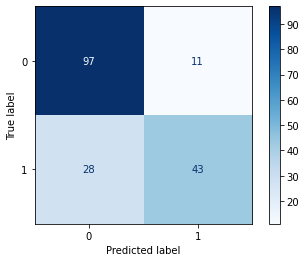

In [49]:
best_lgbm_estimator.fit(X_train, y_train)
y_pred = best_lgbm_estimator.predict(X_test)

plot_confusion_matrix(
    best_lgbm_estimator,
    X_test,
    y_test,
    values_format="d",
    cmap=plt.cm.Blues,
);

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.90      0.83       108
           1       0.80      0.61      0.69        71

    accuracy                           0.78       179
   macro avg       0.79      0.75      0.76       179
weighted avg       0.78      0.78      0.78       179



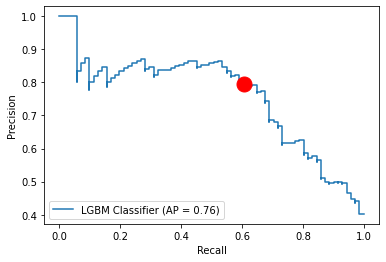

In [51]:
prc = plot_precision_recall_curve(best_lgbm_estimator, X_test, y_test, name="LGBM Classifier")
plt.plot(
    recall_score(y_test, y_pred),
    precision_score(y_test, y_pred),
    "or",
    markersize=15,
);

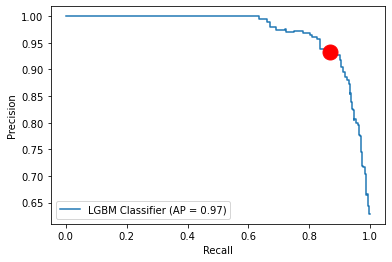

In [52]:
prc = plot_precision_recall_curve(best_lgbm_estimator, X_train, y_train, name="LGBM Classifier")
plt.plot(
    recall_score(y_train, best_lgbm_estimator.predict(X_train)),
    precision_score(y_train, best_lgbm_estimator.predict(X_train)),
    "or",
    markersize=15,
);

## 12.2 Test results with CatBoost Classifier

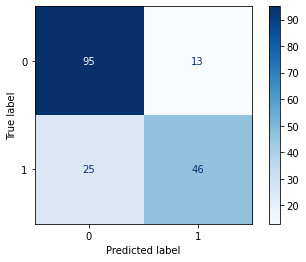

In [53]:
cat_estimator = make_pipeline(
    preprocessor,
    CatBoostClassifier(
        verbose=0,
        random_state=chosen_seed,
        thread_count=-1,
        # class_weights=[1, 1.63],
    ),
)

cat_estimator.fit(X_train, y_train)
y_pred = cat_estimator.predict(X_test)

plot_confusion_matrix(
    cat_estimator,
    X_test,
    y_test,
    values_format="d",
    cmap=plt.cm.Blues,
);

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       108
           1       0.78      0.65      0.71        71

    accuracy                           0.79       179
   macro avg       0.79      0.76      0.77       179
weighted avg       0.79      0.79      0.78       179



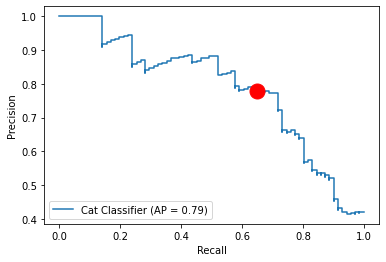

In [55]:
prc = plot_precision_recall_curve(cat_estimator, X_test, y_test, name="Cat Classifier")
plt.plot(
    recall_score(y_test, y_pred),
    precision_score(y_test, y_pred),
    "or",
    markersize=15,
);

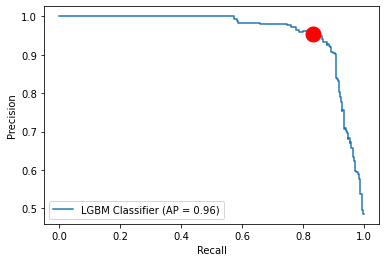

In [56]:
prc = plot_precision_recall_curve(cat_estimator, X_train, y_train, name="LGBM Classifier")
plt.plot(
    recall_score(y_train, cat_estimator.predict(X_train)),
    precision_score(y_train, cat_estimator.predict(X_train)),
    "or",
    markersize=15,
);

# 13. Deployment

## 13.1 Deployment with LGBM model

In [57]:
best_lgbm_estimator.fit(data_df.drop(columns=["Survived"]), data_df.Survived)
# deploy_df
final_prediction = pd.DataFrame(
    best_lgbm_estimator.predict(deploy_df), index=deploy_df.index, columns=["Survived"]
)
final_prediction
final_prediction.to_csv("result/submission_lgbm.csv")

## 13.2 Deployment with CatBoost model

In [58]:
cat_estimator.fit(data_df.drop(columns=["Survived"]), data_df.Survived)
final_prediction = pd.DataFrame(
    cat_estimator.predict(deploy_df), index=deploy_df.index, columns=["Survived"]
)
final_prediction.to_csv("result/submission_cat.csv")

# Iteration 2

## Revision

- Based on our last iteration, Random Forest gave the best result
- However the training accuracy suggests some level of overfitting
- The validation and test accuracy is close to each other

## Overview

- In this iteration we will try to analyze the features in greater details
- We will also try to engineer some new features

In [59]:
# numeric_features

In [60]:
# ordinal_features

In [61]:
# categorical_features

In [62]:
# drop_features

## Cabin Type

In [63]:
# train_df["cabin_type"] = train_df.Cabin.str.slice(stop=1)
# test_df["cabin_type"] = test_df.Cabin.str.slice(stop=1)
# deploy_df["cabin_type"] = deploy_df.Cabin.str.slice(stop=1)
# data_df["cabin_type"] = data_df.Cabin.str.slice(stop=1)

## Log of Fare

In [64]:
# train_df["fare_log"] = np.log(train_df.Fare + 1)
# test_df["fare_log"] = np.log(test_df.Fare + 1)
# deploy_df["fare_log"] = np.log(deploy_df.Fare + 1)
# data_df["fare_log"] = np.log(data_df.Fare + 1)

## Modelling

In [65]:
# numeric_features = ['Age', 'Fare', 'associated_members']
# categorical_features = ['Sex', 'Embarked']
# ordinal_features = ['Pclass', 'is_alone']
# remainder_features = []
# drop_features = ['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', "cabin_type", "fare_log"]
# X_train, y_train = train_df.drop(columns=["Survived"]), train_df["Survived"]
# X_test, y_test = test_df.drop(columns=["Survived"]), test_df["Survived"]

In [66]:
# numeric_pipeline_median = make_pipeline(
#     SimpleImputer(strategy="median"), StandardScaler()
# )
# categorical_pipeline = make_pipeline(
#     SimpleImputer(strategy="most_frequent"),
#     OneHotEncoder(handle_unknown="ignore"),
# )
# ordinal_pipeline = make_pipeline(SimpleImputer(strategy="median"))
# 
# transformers = ColumnTransformer(
#     transformers=[
#         ("num", numeric_pipeline_median, numeric_features),
#         ("cat", categorical_pipeline, categorical_features),
#         ("ord", ordinal_pipeline, ordinal_features)
#     ],
#     remainder="drop"
# )

In [67]:
# pipe_model = make_pipeline(
#     transformers,
#     RandomForestClassifier(
#         min_samples_split=6, n_estimators=1000, random_state=2020, n_jobs=-1
#     ),
# )
# scores = cross_validate(
#     pipe_model, X_train, y_train, cv=5, return_train_score=True, n_jobs=-1
# )
# results_dict={}
# store_cross_val_results("RF Itr2", scores, results_dict)
# pd.DataFrame(results_dict).T

## Hyperparameter Optimization

In [68]:
# param_grid = {
#     "randomforestclassifier__n_estimators": np.arange(940, 951, 1)
# }
# pipe_model = make_pipeline(transformers, RandomForestClassifier(min_samples_split=6, n_jobs=-1, random_state=2020))
# grid_search = GridSearchCV(
#     pipe_model,
#     param_grid,
#     n_jobs=-1,
#     cv=5,
#     return_train_score=True
# )
# grid_search.fit(X_train, y_train)
# print(f"Best parameter: {grid_search.best_params_}")
# print(f"Best validation score: {round(grid_search.best_score_, 3)}")

In [69]:
# cv_scores = pd.DataFrame(grid_search.cv_results_)
# cv_scores = cv_scores.loc[
#     cv_scores["rank_test_score"] == 1,
#     [
#         "params",
#         "mean_train_score",
#         "mean_test_score",
#         "mean_fit_time",
#         "mean_score_time",
#         "std_train_score",
#         "std_test_score",
#     ],
# ].set_index("params")
# cv_scores.columns = [
#     "mean_train_accuracy",
#     "mean_validation_accuracy",
#     "mean_fit_time (s)",
#     "mean_score_time (s)",
#     "std_train_score",
#     "std_test_score",
# ]
# mean_scores_df = pd.concat([mean_scores_df, cv_scores.head(1)])
# mean_scores_df

## Testing

In [70]:
# final_estimator = grid_search.best_estimator_
# 
# final_estimator.fit(X_train, y_train)
# scores = final_estimator.score(X_test, y_test)
# print(f"Test accuracy for our best estimator is: {round(scores, 4)}")
# print(f"Validation accuracy for our best estimator is: {round(mean_scores_df.mean_validation_accuracy[-1], 4)}")
# print(f"Training accuracy for our best estimator is: {round(mean_scores_df.mean_train_accuracy[-1], 4)}")

## Deployment

In [71]:
# final_prediction = pd.DataFrame(
#     final_estimator.predict(deploy_df), index=deploy_df.index, columns=["Survived"]
# )
# final_prediction.to_csv("result/submission.csv")